<a href="https://colab.research.google.com/github/trobinson9/ApolloFinalYearProject/blob/main/BSR_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Required Modules

In [ ]:
! pip install shap
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import lightgbm as lgb
import shap
import math
import itertools
from numpy.core.multiarray import zeros
%matplotlib inline

from pprint import pprint
from IPython.display import display 
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, roc_auc_score, precision_score, log_loss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive  # mount drive for data
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Project Data/processed_data.csv').drop(columns = ['Unnamed: 0', 'Title', 'Name', 'Brand'])  # read pre-processed data
data

,ASIN,n Videos,Base Price,Rating,Description Score,Description Bin,Department Rank,Sub-Department Rank,Department,Sub-Department,...,Mean: An image showcasing a product's effectiveness,Max: An image showcasing a product's effectiveness,Min: An image showcasing a product's effectiveness,Mean: Useful,Max: Useful,Min: Useful,Mean: Unbranded Title,Max: Unbranded Title,Min: Unbranded Title,n Images
0,B09HSH8YKT,0.0,1.81,NaN,4.703251,6.0,NaN,NaN,NaN,NaN,...,0.230321,0.262897,0.209633,0.221413,0.237311,0.201049,0.274804,0.355585,0.151234,8
1,B094QXG23D,0.0,9.39,NaN,4.512032,5.0,NaN,NaN,NaN,NaN,...,0.231551,0.259788,0.214299,0.217060,0.236499,0.204420,0.286007,0.341324,0.177184,8
2,B09KH39RHV,0.0,4.62,NaN,4.347838,4.0,NaN,NaN,NaN,NaN,...,0.219192,0.262897,0.202536,0.201708,0.232498,0.181251,0.235375,0.304492,0.190385,8
3,B07BFWGDZG,0.0,5.99,5.0,4.316766,4.0,1204181.0,1864.0,home & kitchen,tea pots,...,0.229986,0.262897,0.202992,0.213576,0.232498,0.199176,0.320455,0.360467,0.188404,6
4,B0BQVBY7D1,0.0,4.09,NaN,4.675052,6.0,NaN,NaN,NaN,NaN,...,0.218992,0.262897,0.187567,0.207581,0.232498,0.179427,0.251728,0.317527,0.168969,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12795,B09T5RN7T9,0.0,9.49,NaN,4.190913,3.0,NaN,NaN,NaN,NaN,...,0.245330,0.257943,0.226408,0.225934,0.241305,0.205404,0.303942,0.350042,0.177983,8
12796,B09ZPC73CP,0.0,186.88,NaN,4.842924,6.0,NaN,NaN,NaN,NaN,...,0.217521,0.245057,0.203756,0.199486,0.220694,0.185719,0.290570,0.332047,0.194831,8
12797,B0B7X2VMKN,0.0,39.86,NaN,4.044750,2.0,NaN,NaN,NaN,NaN,...,0.219716,0.228513,0.206512,0.224041,0.235561,0.199977,0.244460,0.279828,0.188967,7
12798,B09GB9S91N,0.0,18.67,NaN,3.836184,2.0,NaN,NaN,NaN,NaN,...,0.240384,0.250679,0.222564,0.226052,0.241918,0.203543,0.296286,0.348321,0.186727,8


In [ ]:
data['n Images'] = data['n Images'].replace(512, 1)  # replace error in data processing

In [ ]:
def num_string_to_list(num_str):  # convert to list of numbers from string stored in csv
  return [float(num) for num in num_str.split('[')[1].split(']')[0].split(', ')]

In [ ]:
def tensor_string_to_list(csv_str):  # convert tensor list stored in csv as string
  num_tensors = len(csv_str.split('tensor')) - 1
  if num_tensors == 1:
    stripped_str = csv_str.split('tensor([')[1].split('])')[0].replace('\n', "")
    float_list = [float(num_str) for num_str in stripped_str.split(',')]
    return float_list
  elif num_tensors < 1:
    print('error in string')
    return np.NaN
  elif num_tensors > 1:
    tensor_list = csv_str.split('tensor([')
    float_list_list = []
    for i in range(num_tensors):
      stripped_str = tensor_list[i+1].replace(']), ', '').replace('\n', '').replace('])]', '')
      float_list = [float(num_str) for num_str in stripped_str.split(',')]
      float_list_list.append(float_list)
    return float_list_list

In [ ]:
comp_home_data = data[data['Department'].isin(['home & kitchen'])].drop(columns=['Department']) # , np.NaN]  # select data from home & kitchen department
comp_home_data = comp_home_data.loc[comp_home_data[comp_home_data['Min: Unbranded Title'] > 0.01].index]  # remove any abnormally low similarity scores

In [ ]:
def catagorise_dep_rank(dep_rank, boundaries):  # categorise BSR from 0-n based on boundaries provided
  if type(dep_rank) == str:
    return dep_rank

  if dep_rank <= boundaries[0]:
    return 0

  for i in range(len(boundaries)-1):
    if boundaries[i]-1 < dep_rank <= boundaries[i+1]:
      return i+1

  if dep_rank > boundaries[len(boundaries)-1]:
    return len(boundaries)
  else:
    return dep_rank

In [ ]:
n_cats = 5  # number categories for BSR
quant_step = 1/n_cats
dep_splits = comp_home_data['Department Rank'].quantile(np.arange(quant_step, 1-quant_step, quant_step))  # get BSR category boundaries according to quantiles for even split
cats = ['Top 150k', '150-500k', '500-1300k', '1300-2400k', 'Below 2400k', 'unranked']  # string array of categories for labelling graphs
dep_splits

0.2     148418.6
0.4     517984.6
0.6    1307767.6
0.8    2405681.0
Name: Department Rank, dtype: float64

In [ ]:
comp_home_data['Department Rank'] = comp_home_data['Department Rank'].fillna( len(dep_splits.values)+1 ).apply(lambda x: catagorise_dep_rank(dep_rank=x, boundaries=dep_splits.values))  # apply categorisation function

In [ ]:
unranked_sample = data.drop(data.dropna(subset = ['Department']).index).sample(n = comp_home_data['Department Rank'].value_counts()[0]).drop(columns = ['Department'])  # get sample of unranked listings equal size to other categories
comp_home_data = pd.concat([comp_home_data, unranked_sample],axis=0, sort=False)  # add unranked sample to data
comp_home_data['Department Rank'] = comp_home_data['Department Rank'].fillna(len(dep_splits) + 1)  # label unranked samples
comp_home_data['Department Rank'].value_counts()

2.0    444
0.0    444
4.0    444
5.0    444
1.0    443
3.0    443
Name: Department Rank, dtype: int64

In [ ]:
cat_features = ['n Images', 'n Videos', 'Description Bin'] # list of categorical columns to be fed into model
home_data_tranform = comp_home_data  # new dataframe before final processing is applied

In [ ]:
home_data_tranform = home_data_tranform.drop(columns = ['ASIN', 'Sub-Department Rank', 'Sub-Department', 'Unbranded Title',	'Unbranded Name'])  # drop unnused columns
home_data_tranform = home_data_tranform.drop(columns = ['Description Score'])  # drop description score, description bin found to be more useful
home_data_tranform['Rating'] = home_data_tranform['Rating'].fillna(np.mean(comp_home_data['Rating']))  # replace missing ratings with mean, deemed to be more effective than 0
home_data_tranform = home_data_tranform.dropna(subset=['Base Price']).reset_index().drop(columns='index')  # remove listings missing price
home_data_tranform['Normalised Deal Saving'] = home_data_tranform['Normalised Deal Saving'].fillna(0.0)  # where there is no deal deal saving is 0
home_data_tranform['Base Price'] = home_data_tranform['Base Price'].apply(math.log)  # log of price found to be more effective
home_data_tranform.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2662 entries, 0 to 2661
Data columns (total 52 columns):
 #   Column                                                                                    Non-Null Count  Dtype  
---  ------                                                                                    --------------  -----  
 0   n Videos                                                                                  2662 non-null   float64
 1   Base Price                                                                                2662 non-null   float64
 2   Rating                                                                                    2662 non-null   float64
 3   Description Bin                                                                           2662 non-null   float64
 4   Department Rank                                                                           2662 non-null   float64
 5   Normalised Deal Saving                                 

Seperate image features data for analysis

In [ ]:
img_feat_columns = []  # identify and list columns which contain image features
for column in home_data_tranform.columns:
  if 'Mean:' in column:
    img_feat_columns.append(column)
  if 'Min:' in column:
    img_feat_columns.append(column)
  if 'Max:' in column:
    img_feat_columns.append(column)

In [ ]:
img_feat_data = home_data_tranform[img_feat_columns]  # move image feature data to new dataframe
home_data_tranform = home_data_tranform.drop(columns = img_feat_columns)  # remove image feature data
img_feat_data.columns = img_feat_data.columns.str.replace(':', '')  # remove colons from list of image feature columns to allow iteration
img_feat_data.columns

Index(['Mean An effective advertisement', 'Max An effective advertisement',
       'Min An effective advertisement', 'Mean An image showing extra detail',
       'Max An image showing extra detail',
       'Min An image showing extra detail', 'Mean A best selling amazon image',
       'Max A best selling amazon image', 'Min A best selling amazon image',
       'Mean An image of a best selling product',
       'Max An image of a best selling product',
       'Min An image of a best selling product', 'Mean A well framed product',
       'Max A well framed product', 'Min A well framed product',
       'Mean Does the image accurately reflect the product's price point and value proposition?',
       'Max Does the image accurately reflect the product's price point and value proposition?',
       'Min Does the image accurately reflect the product's price point and value proposition?',
       'Mean An image showing a specific detail clearly',
       'Max An image showing a specific detail clea

Iterate through combinations of image features used and test model accuracy for each

In [ ]:
iterations = 10

y = home_data_tranform['Department Rank']
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

num_classes = len(y.value_counts())  # number of classes of BSR

params = {  # optimal params for model
    'objective' : 'multiclass',
    'num_class' : num_classes,
    'num_leaves' : num_classes,
    'max_depth': 30,
    'learning_rate' : 0.1,
    # 'feature_fraction' : 0.6,
    'verbosity' : -1
}

test_columns = img_feat_data.columns[0:9]  # test the top 3 correlated img features (list still in order and mean, min, max for each)
ave_accuracies = pd.DataFrame(columns=['Columns Used', 'Log Loss Score', 'Weighted Accuracy', 'Per Category Accuracy'])  # empy dataframe to populate with results
for L in range(len(test_columns) + 1):
    for subset in itertools.combinations(test_columns, L):  # iterate through each combination
        print(subset)
        features = list(subset)
        used_img_feats = img_feat_data[features]  # select image data to include
        x = home_data_tranform.drop(columns = ['Department Rank']).join(used_img_feats)  # add image data to x
        
        tot_accuracy_scores = zeros(num_classes)
        tot_log_loss = 0
        tot_weighted_accuracy = 0
        for i in range(iterations):  # repeat model training for many iterations to reduce random variation
          # train is now 75% of the entire data set
          train_x, test_x, train_y, test_y = train_test_split(x, y, test_size= (1 - train_ratio))

          # test is now 10% of the initial data set
          # validation is now 15% of the initial data set
          valid_x, test_x, valid_y, test_y = train_test_split(test_x, test_y, test_size= test_ratio/(test_ratio + validation_ratio)) 


          # Create the LightGBM data containers
          # Make sure that cat_features are used
          train_data=lgb.Dataset(train_x,label=train_y, categorical_feature = cat_features)
          valid_data=lgb.Dataset(valid_x,label=valid_y, categorical_feature = cat_features)

          lgbm = lgb.train(params,  # train model
                train_data,
                2500,
                valid_sets=valid_data,
                early_stopping_rounds= 30,
                # verbosity = -1
                verbose_eval= -100
                )

          pred_y = lgbm.predict(test_x)  # predict test values
          pred_y_vals = [np.argmax(line) for line in pred_y]  # get predicted bin from values
          accuracy = precision_score(pred_y_vals,test_y.values,average=None)  # get accuracy for each category
          weighted_accuracy = precision_score(pred_y_vals,test_y.values,average='weighted')  # get weighted accuracy for all categories
          tot_weighted_accuracy = tot_weighted_accuracy + weighted_accuracy 
          tot_accuracy_scores = tot_accuracy_scores + accuracy
          log_loss_score = log_loss(test_y.values, pred_y)  # get log loss score
          tot_log_loss = tot_log_loss + log_loss_score
        ave_accuracy = tot_accuracy_scores/iterations  # get average for from total of each metric by dividing by iterations
        ave_log_loss = tot_log_loss/iterations
        overall_accuracy = tot_weighted_accuracy/iterations
        ave_accuracies.loc[len(ave_accuracies)] = {'Columns Used': subset, 'Log Loss Score': ave_log_loss, 'Weighted Accuracy': overall_accuracy, 'Per Category Accuracy': ave_accuracy}  # populate results df

ave_accuracies

In [ ]:
best_results = ave_accuracies.sort_values('Log Loss Score', ascending = True).reset_index(drop=True)  # get best combinations of image data by log loss score
best_img_feats = list(best_results['Columns Used'][0])
best_results

In [ ]:
home_data_tranform = home_data_tranform.join(img_feat_data[best_results]  # join with calculated best results or saved best results below
# home_data_tranform = home_data_tranform.join(img_feat_data[['Mean An image showing extra detail', 'Min An image showing extra detail', 'Mean A best selling amazon image', 'Max A best selling amazon image']])

Generate Model Learning Curve

In [ ]:
samples = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]  # sample sizes for data
iterations = 100

y = home_data_tranform['Department Rank']
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

num_classes = len(y.value_counts())  # number of BSR classes

params = {
    'objective' : 'multiclass',
    'num_class' : num_classes,
    'num_leaves' : num_classes,
    'max_depth': 30,
    'learning_rate' : 0.1,
    # 'feature_fraction' : 0.6,
    'verbosity' : -1
}
ave_accuracies = pd.DataFrame(columns=['Sample Size', 'num cats', 'Log Loss', 'Weighted Accuracy', 'Overall Accuracy', 'Per Category Accuracy', 'Cat 0', 'Cat 1', 'Cat 2', 'Cat 3', 'Cat 4', 'Cat 5']) # results df
# ave_accuracies.columns = ['Columns Used', 'Overall Accuracy', 'Per Category Accuracy']
for sample_size in samples:  # for each sample size
  sample = home_data_tranform.sample(frac=sample_size)  # take random sample
  x = sample.drop(columns = ['Department Rank'])
  y = sample['Department Rank']

  num_cats = len(y.value_counts())  # get number of BSR categories in sample
  tot_accuracy_scores = zeros(num_cats)
  tot_log_loss = 0
  tot_weighted_accuracy = 0
  for i in range(iterations):
    # train is now 75% of the entire data set
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size= (1 - train_ratio))

    # test is now 10% of the initial data set
    # validation is now 15% of the initial data set
    valid_x, test_x, valid_y, test_y = train_test_split(test_x, test_y, test_size= test_ratio/(test_ratio + validation_ratio)) 

    # train_x, valid_x, train_y, valid_y = train_test_split(home_data_tranform.drop(columns = ['Department Rank']), y, test_size=0.2, shuffle=True, random_state=1)  # , stratify=y

    # Create the LightGBM data containers
    # Make sure that cat_features are used
    train_data=lgb.Dataset(train_x,label=train_y, categorical_feature = cat_features)
    valid_data=lgb.Dataset(valid_x,label=valid_y, categorical_feature = cat_features)

    lgbm = lgb.train(params,
          train_data,
          2500,
          valid_sets=valid_data,
          early_stopping_rounds= 30,
          # verbosity = -1
          verbose_eval= -100
          )

    pred_y = lgbm.predict(test_x)
    pred_y_vals = [np.argmax(line) for line in pred_y]  # ave ratings and sub-department removed and even splits on test set and listing age removed
    accuracy = precision_score(pred_y_vals,test_y.values,average=None)
    tot_accuracy_scores = tot_accuracy_scores + accuracy
    log_loss_score = log_loss(test_y.values, pred_y, labels = [0, 1, 2, 3, 4, 5])
    tot_log_loss = tot_log_loss + log_loss_score
    weighted_accuracy = precision_score(pred_y_vals,test_y.values,average='weighted')
    tot_weighted_accuracy = tot_weighted_accuracy + weighted_accuracy
  ave_accuracy = tot_accuracy_scores/iterations
  overall_accuracy = np.mean(ave_accuracy)
  ave_log_loss = tot_log_loss/iterations
  ave_weighted_accuracy = tot_weighted_accuracy/iterations
  ave_accuracies.loc[len(ave_accuracies)] = {'Sample Size': sample_size, 'num cats': num_cats, 'Log Loss': ave_log_loss, 'Weighted Accuracy': ave_weighted_accuracy, 'Overall Accuracy': overall_accuracy, 'Per Category Accuracy': ave_accuracy,
                                             'Cat 0':ave_accuracy[0], 'Cat 1':ave_accuracy[1], 'Cat 2':ave_accuracy[2], 'Cat 3':ave_accuracy[3], 'Cat 4':ave_accuracy[4], 'Cat 5':ave_accuracy[5]  }  # 

ave_accuracies

Training until validation scores don't improve for 30 rounds


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Early stopping, best iteration is:
[153]	valid_0's multi_logloss: 1.27902


,Sample Size,num cats,Log Loss,Weighted Accuracy,Overall Accuracy,Per Category Accuracy,Cat 0,Cat 1,Cat 2,Cat 3,Cat 4,Cat 5
0,1,6,1.271289,0.544763,0.52852,"[0.6382978723404256, 0.47058823529411764, 0.48...",0.638298,0.470588,0.487179,0.340909,0.6,0.634146


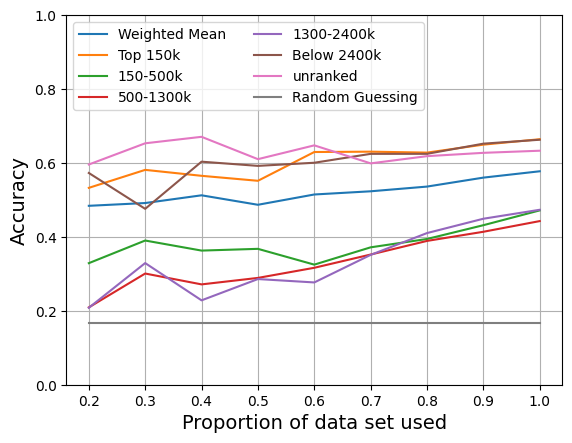

In [ ]:
plt.plot(ave_accuracies['Sample Size'], ave_accuracies['Weighted Accuracy'])  # plot accuracy improvement curves
plt.ylim([0, 1])
plt.xlabel("Proportion of data set used", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
for cat in ['Cat 0', 'Cat 1', 'Cat 2', 'Cat 3', 'Cat 4', 'Cat 5', ]:
  plt.plot(ave_accuracies['Sample Size'], ave_accuracies[cat])
plt.plot(ave_accuracies['Sample Size'], np.ones(len(ave_accuracies))*1/6)
plt.legend(['Weighted Mean'] + cats + ['Random Guessing'], loc = 'upper left', ncol=2, fontsize=10)
plt.grid(which = 'major')

 Implement User Listing Feedback Using Model

In [ ]:
home_data_tranform_feats = home_data_tranform.drop(columns=['Department Rank']) # get features data
n = 134
test = home_data_tranform_feats.iloc[n]  # select random 'n' listing test

# Predict a new value using lgbm for 'test'
new_value = lgbm.predict(test)
actual_value = home_data_tranform['Department Rank'][n]

avg = home_data_tranform_feats.mean()  # average metrics from data
top_100k_avg = home_data_tranform[home_data_tranform['Department Rank'] == 0].drop(columns=['Department Rank']).mean()  # average from best category
min_val = home_data_tranform_feats.min()  # min from each data point
max_val = home_data_tranform_feats.max()  # max from each data point
test_norm = (test - min_val) / (max_val - min_val)  # normalise test listing data
avg_norm = (avg - min_val) / (max_val - min_val)  # normalise ave data
top_150k_avg_norm = (top_100k_avg - min_val) / (max_val - min_val)  # normalise best category ave data

Converting data to scipy sparse matrix.


In [ ]:
x_ticks = ['n Videos', 'Base Price', 'Rating', 'Description Score',  # define x labels for neater graph
       'Normalised Deal \n Saving', 'n Images',
       'Mean An image \n showing extra detail',
       'Min An image \n showing extra detail',
       'Mean A best \n selling amazon image',
       'Max A best \n selling amazon image']

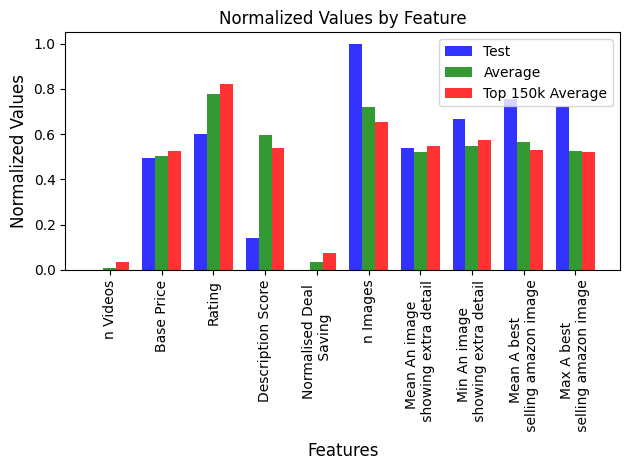

Predicted Dep Rank: 1
Actual Dep Rank: 1.0


In [ ]:
fig, ax = plt.subplots()  # display test, average, and best category average data for user
index = np.arange(len(test_norm.index))
bar_width = 0.25
opacity = 0.8

test_plt = ax.bar(index, test_norm.values, bar_width,
                alpha=opacity, color='b',
                label='Test')

avg_plt = ax.bar(index + bar_width, avg_norm.values, bar_width,
                alpha=opacity, color='g',
                label='Average')

top_avg_plt = ax.bar(index + 2*bar_width, top_150k_avg_norm.values, bar_width,
                alpha=opacity, color='r',
                label='Top 150k Average')

ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Normalized Values', fontsize=12)
ax.set_title('Normalized Values by Feature')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(x_ticks, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()
print('Predicted Dep Rank: ' + str(new_value.argmax()))
print('Actual Dep Rank: ' + str(actual_value))

Plot Importance of features in model

In [ ]:
x_cols = ['n Videos', 'Base Price', 'Rating', 'Description Bin',
       'Normalised Deal \n Saving', 'n Images',
       'Mean An image showing\nextra detail',
       'Min An image showing\nextra detail', 'Mean A best selling \n amazon image',
       'Max A best selling\n amazon image']

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plotImp(model, X , num = 20, fig_size = (8, 7)):
    feature_imp = pd.DataFrame({'Feature Importance (Gain)':model.feature_importance(importance_type = 'gain'),'Feature':x_cols})  # get feature importances in gain
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 1.2)
    sns.barplot(y="Feature Importance (Gain)", x="Feature", data=feature_imp.sort_values(by="Feature Importance (Gain)", 
                                                        ascending=False)[0:num])
    # plt.title('Weight of Features in Model')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

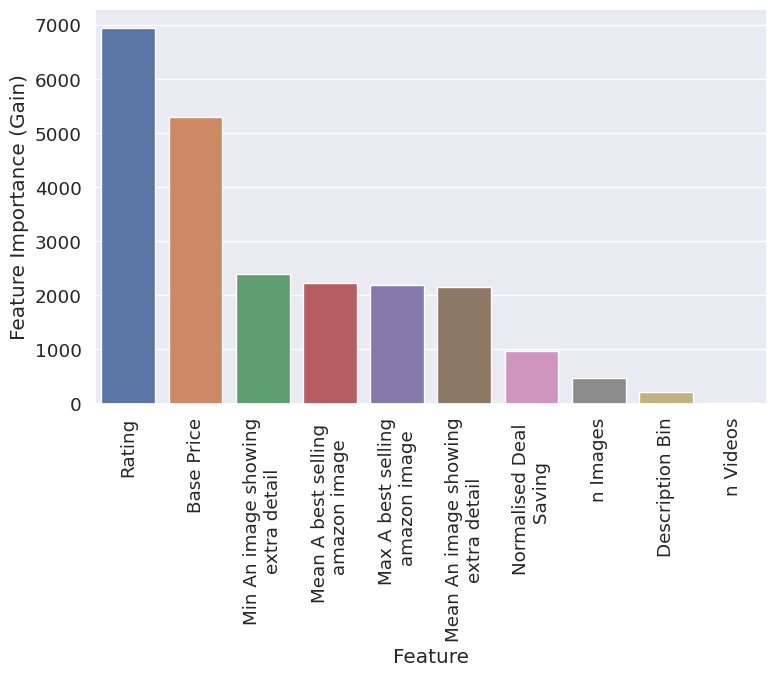

In [ ]:
plotImp(lgbm, x)